From ChatGPT:

Using Nested Sampling to marginalize over the likelihood while selecting hyperparameters for the kernel of a Gaussian process is a valuable approach in Bayesian model selection and hyperparameter optimization. This technique allows you to consider the uncertainty in the hyperparameters and efficiently explore the model space. Here's a step-by-step guide on how to do this:

1. **Set Up the Gaussian Process Model**:
   - Define your Gaussian process model, including the kernel and the likelihood function. The kernel typically includes hyperparameters that you want to optimize or marginalize over.

2. **Choose Priors for Hyperparameters**:
   - Define prior distributions for the hyperparameters of the kernel. Priors represent your prior beliefs about the values of these hyperparameters. The choice of priors depends on your prior knowledge about the system or problem.

3. **Construct the Likelihood Function**:
   - Build the likelihood function that quantifies how well the model with specific hyperparameters fits the observed data. This function should take the model's predictions and compare them to the observed data while incorporating the likelihood of measurement errors.

4. **Configure Nested Sampling**:
   - Choose a Nested Sampling algorithm (e.g., MultiNest, Dynesty) and configure it. Set parameters such as the number of live points, stopping criteria, and the likelihood function defined in the previous step. The hyperparameters of the kernel should also be treated as parameters in the Nested Sampling run.

5. **Run Nested Sampling**:
   - Execute the Nested Sampling algorithm with the configured settings. Nested Sampling will explore the parameter space, including the hyperparameters of the kernel, and provide samples from the posterior distribution of these hyperparameters.

6. **Estimate the Evidence**:
   - One of the primary goals of Nested Sampling is to estimate the Bayesian evidence, which quantifies how well the model with specific hyperparameters fits the data. The evidence accounts for the uncertainty in the hyperparameters and the model's goodness of fit.

7. **Obtain Posterior Samples**:
   - In addition to estimating the evidence, Nested Sampling provides posterior samples of the hyperparameters. These samples represent the most likely values for the hyperparameters given the data and allow you to quantify the uncertainty in hyperparameter estimates.

8. **Analyze and Select Hyperparameters**:
   - Analyze the posterior samples of the hyperparameters to determine the most likely values and their uncertainties. You can use this information for model selection, hyperparameter optimization, and to make more informed decisions about the choice of the kernel's hyperparameters.

9. **Model Comparison and Selection**:
   - You can perform model comparison by comparing the Bayesian evidence for different kernel hyperparameters. The model with the highest evidence is the most favored by the data.

10. **Repeat if Necessary**:
    - If your prior beliefs about the hyperparameters change or you need to update the model, you can repeat the Nested Sampling process to explore the new parameter space and obtain updated results.

By using Nested Sampling in this way, you can effectively marginalize over the likelihood and estimate the posterior distribution of kernel hyperparameters, accounting for the uncertainties in the model and data. This approach is particularly useful in scenarios where hyperparameter selection is essential for the performance of the Gaussian process model.

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import GPy
import dynesty as dy
import scipy

%matplotlib notebook

<IPython.core.display.Javascript object>


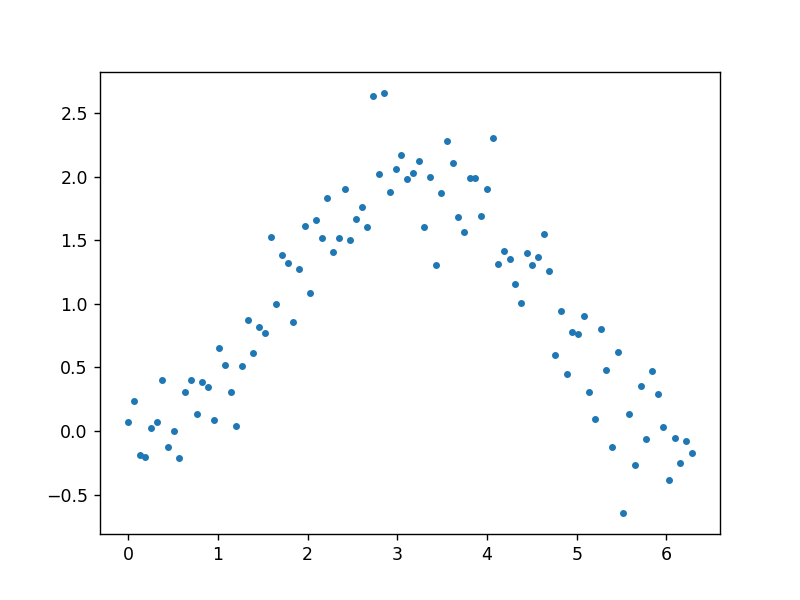

In [2]:
# Let's make some synthetic data
x = np.linspace(0.,2*np.pi,100)[:,None]
y = -np.cos(x)+np.random.randn(*x.shape)*0.3+1
_ = plt.plot(x,y,'.')

reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


<IPython.core.display.Javascript object>


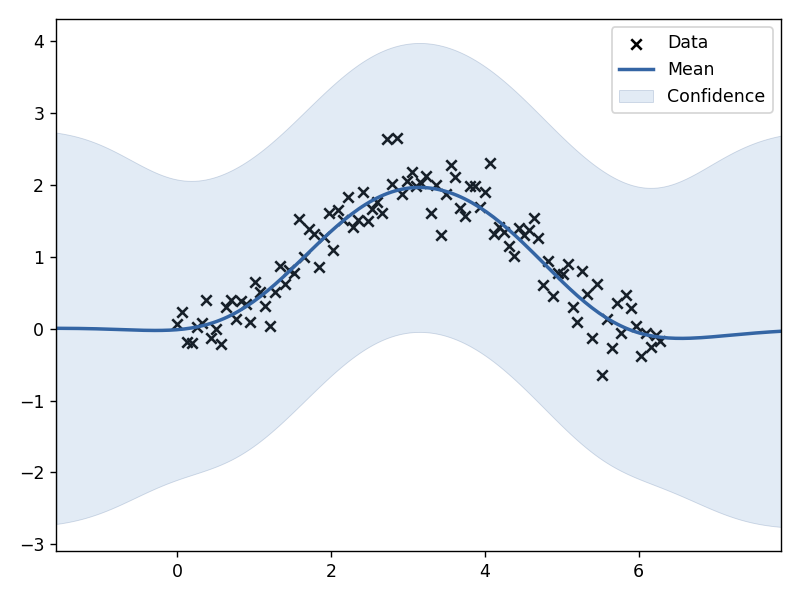

In [3]:
# Make a GP regression model
m = GPy.models.GPRegression(x,y)
# Give some general prior distributions for model parameters
m.kern.lengthscale.set_prior(GPy.priors.Gamma.from_EV(1.,10.))
m.kern.variance.set_prior(GPy.priors.Gamma.from_EV(1.,10.))
m.likelihood.variance.set_prior(GPy.priors.Gamma.from_EV(1.,10.))
_=m.plot()

In [15]:
m

GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,"Ga(0.1, 0.1)"
rbf.lengthscale,1.0,+ve,"Ga(0.1, 0.1)"
Gaussian_noise.variance,1.0,+ve,"Ga(0.1, 0.1)"


# Dynesty part

In [24]:
# Define the dimensionality of our problem.
ndim = 3

# Define our 3-D correlated multivariate normal likelihood.
C = np.identity(ndim)  # set covariance to identity matrix
C[C==0] = 0.95  # set off-diagonal terms
Cinv = np.linalg.inv(C)  # define the inverse (i.e. the precision matrix)
lnorm = -0.5 * (np.log(2 * np.pi) * ndim +
                np.log(np.linalg.det(C)))  # ln(normalization)

def loglike(x):
    """The log-likelihood function."""

    return -0.5 * np.dot(x, np.dot(Cinv, x)) + lnorm

# Define our uniform prior.
def ptform(u):
    """Transforms the uniform random variables `u ~ Unif[0., 1.)`
    to the parameters of interest."""
    
    x = np.array(u) # Copy u
    
    alpha = 10.
    for i in range(2):
    # Gamma
        x[i] = scipy.stats.gamma.ppf(u[i], alpha)
    
    return x

In [25]:
sampler = dy.NestedSampler(loglike, ptform, ndim)
sampler.run_nested()
results = sampler.results

13616it [00:43, 309.47it/s, +500 | bound: 53 | nc: 1 | ncall: 58471 | eff(%): 24.350 | loglstar:   -inf < -0.873 <    inf | logz: -27.500 +/-  0.237 | dlogz:  0.001 >  0.509]


<IPython.core.display.Javascript object>


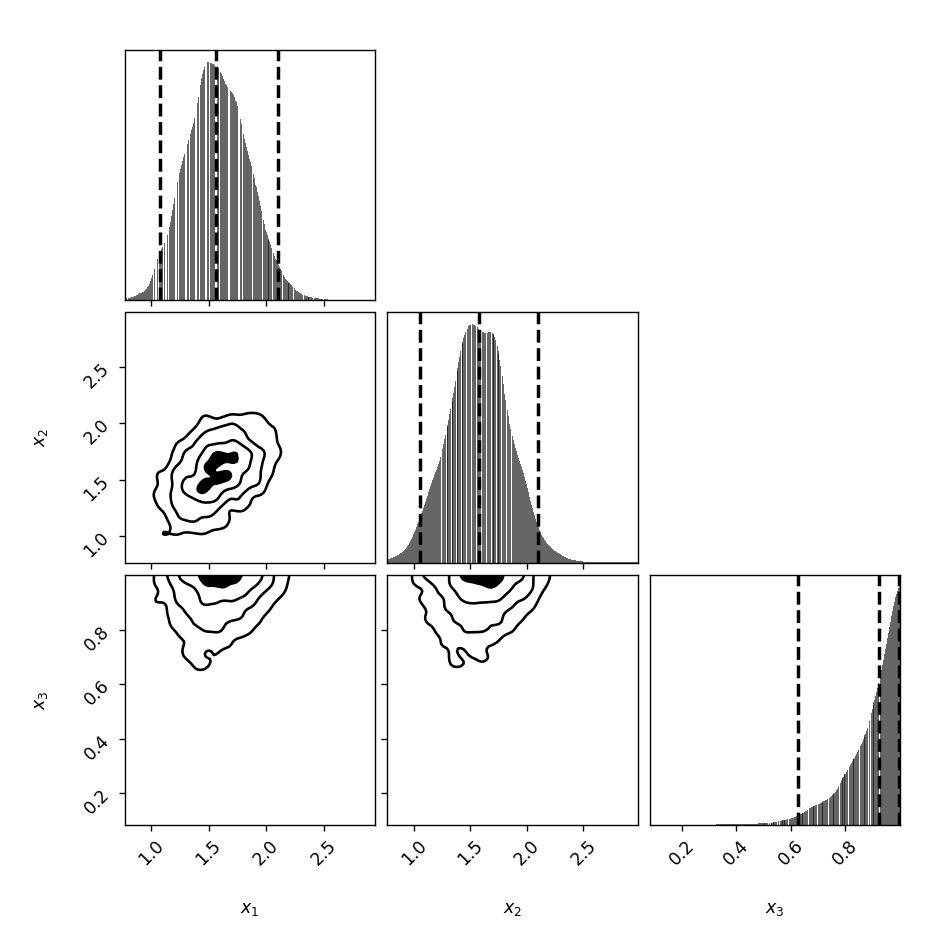

In [27]:
from dynesty import plotting as dyplot
_, _ = dyplot.cornerplot(results)

In [28]:
from dynesty import utils as dyfunc

# Extract sampling results.
samples = results.samples  # samples
weights = results.importance_weights()

# Compute weighted mean and covariance.
mean, cov = dyfunc.mean_and_cov(samples, weights)


Name : GP regression
Objective : 105.50753902633016
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |     priors   
  rbf.variance             |   3.625579077577013  |      +ve      |  Ga(0.1, 0.1)
  rbf.lengthscale          |    3.61583994916653  |      +ve      |  Ga(0.1, 0.1)
  Gaussian_noise.variance  |  0.7548152423412108  |      +ve      |  Ga(0.1, 0.1)


<IPython.core.display.Javascript object>


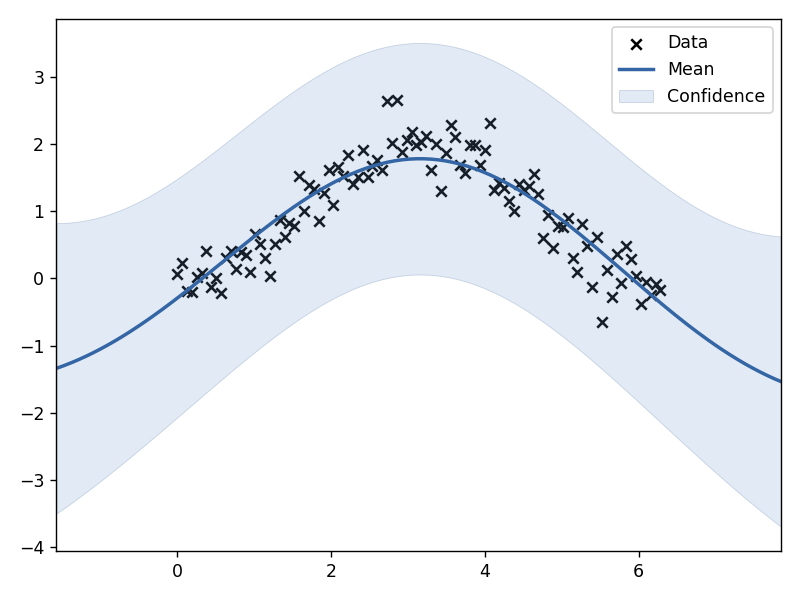

In [31]:
# Set the model parameters as the posterior mean
m.kern.variance[:] = samples[:,0].mean()
m.kern.lengthscale[:] = samples[:,1].mean()
m.likelihood.variance[:] = samples[:,2].mean()
print(m)
_=m.plot()

## Verdict: ???/10